In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip # This is our dataset link. I will include this command in the description


--2023-01-23 20:11:29--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2023-01-23 20:11:30--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  18.3MB/s    in 2m 42s  

2023-01-23 20:14:12 (20.8 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize, Normalize
from torch.utils.data import DataLoader, Dataset
from torch.autograd import set_detect_anomaly


import math
from PIL import Image
import os
from os import listdir
import tqdm.notebook as tq
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

In [ ]:
set_detect_anomaly(True)

In [ ]:
lr_size=100
hr_size=200

In [ ]:

def is_image_file(filename):
    return filename.endswith('.png') 


def train_hr_transform(crop_size):
    return Compose([
            RandomCrop(int(crop_size)),
            ToTensor(),
        ])


def train_lr_transform(lr_size):
    interp=torchvision.transforms.InterpolationMode.BILINEAR 
    return Compose([
            ToPILImage(),
            Resize(int(lr_size), interpolation=interp),
            ToTensor(),
        ])

class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, lr_size, hr_size):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        self.hr_transform = train_hr_transform(hr_size)
        self.lr_transform = train_lr_transform(lr_size)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [ ]:
train_set = TrainDatasetFromFolder("DIV2K_train_HR", lr_size, hr_size)
trainloader = DataLoader(train_set, batch_size=25, shuffle=True)

In [ ]:
class RES(nn.Module):
    def __init__(self,channel):
        super(RES,self).__init__()
        self.net=nn.Sequential(
            nn.Conv2d(channel,channel,kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(channel),
            nn.Conv2d(channel,channel,kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(channel)
        )
    def forward(self,x):
        return self.net(x)+x

class NET(nn.Module):
    def __init__(self):
        super(NET,self).__init__()
        self.up=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear')
        )
        self.net=self.resnet=nn.Sequential(
            RES(64),
            RES(64),
            RES(64),
            RES(64),
            RES(64),
            RES(64),
            RES(64),
            RES(64)            
        )

        self.last=nn.Conv2d(64,3,kernel_size=9,padding=4)
    def forward(self,x):
        up=self.up(x)
        net=self.net(up)
        res=self.last(up+net)
        return (torch.tanh(res)+1)/2

class DSC(nn.Module):
    def __init__(self):
        super(DSC,self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=1)

        )
    def forward(self,x):
        batch_size=x.size()[0]
        return torch.sigmoid(self.net(x).view(batch_size))

In [ ]:
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight=tv_loss_weight
    def forward(self, x):
        batch_size=x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]

        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])

        h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
        w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size
    
    # Forgot to implement an important method
    @staticmethod # Must add this
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        vgg=torchvision.models.vgg.vgg16(weights="DEFAULT")
        vgg = nn.Sequential(*list(vgg.features)).eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg=vgg
        self.mse=nn.MSELoss()
        
    def forward(self,opt_img,real_img):
        vgg_opt=self.vgg(opt_img)
        vgg_real=self.vgg(real_img)
        vgg_loss=self.mse(vgg_opt,vgg_real)
        return vgg_loss

class VGGLoss2(nn.Module):
    def __init__(self):
        super(VGGLoss2, self).__init__()
        vgg=torchvision.models.vgg.vgg16(weights="DEFAULT").eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg=vgg
        self.mse=nn.MSELoss()
        
    def forward(self,opt_img,real_img):
        vgg_opt=self.vgg(opt_img)
        vgg_real=self.vgg(real_img)
        vgg_loss=self.mse(vgg_opt,vgg_real)
        return vgg_loss


class COLORLoss(nn.Module):
    def __init__(self):
        super(COLORLoss, self).__init__()
        self.mse=nn.MSELoss()
    def forward(self,fake_img,real_img):
        r_g_ratio_fake=torch.tanh(fake_img[:,0,:,:]/(fake_img[:,1,:,:]+0.001)+1)/2
        r_g_ratio_real=torch.tanh(real_img[:,0,:,:]/(real_img[:,1,:,:]+0.001)+1)/2
        g_b_ratio_fake=torch.tanh(fake_img[:,1,:,:]/(fake_img[:,2,:,:]+0.001)+1)/2
        g_b_ratio_real=torch.tanh(real_img[:,1,:,:]/(real_img[:,2,:,:]+0.001)+1)/2
        b_r_ratio_fake=torch.tanh(fake_img[:,2,:,:]/(fake_img[:,0,:,:]+0.001)+1)/2
        b_r_ratio_real=torch.tanh(real_img[:,2,:,:]/(real_img[:,0,:,:]+0.001)+1)/2
        
        r_g_loss=self.mse(r_g_ratio_fake,r_g_ratio_real)
        g_b_loss=self.mse(g_b_ratio_fake,g_b_ratio_real)
        b_r_loss=self.mse(b_r_ratio_fake,b_r_ratio_real)
        
        return (r_g_loss+g_b_loss+b_r_loss)/3


class ASDFLoss(nn.Module):
    def __init__(self):
        super(ASDFLoss, self).__init__()
        self.tv_loss = TVLoss()
        self.vgg_loss=VGGLoss()
        self.vgg_loss2=VGGLoss2()
        self.mse_loss=nn.MSELoss()
        self.color_loss=COLORLoss()
        
    def forward(self, opt_img, real_img,fake_out):
        adv_loss=1-fake_out
        tv_loss = self.tv_loss(opt_img)
        vgg_loss=self.vgg_loss(opt_img,real_img)
        vgg_loss2=self.vgg_loss2(opt_img,real_img)
        mse_loss=self.mse_loss(opt_img,real_img)
        color_loss=self.color_loss(opt_img,real_img)
        asdf_loss=tv_loss*1e-3 + vgg_loss/2 +vgg_loss2/10 + mse_loss + adv_loss/10 + color_loss*5e-2
        return asdf_loss

In [ ]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cuda')

In [ ]:
net=torch.load('res_model_net.pt')
dsc=torch.load('res_model_dsc.pt')

In [ ]:
net=NET().to(device)
dsc=DSC().to(device)

In [ ]:
net_criterion=ASDFLoss().to(device)

In [ ]:
net_optimizer=torch.optim.SGD(net.parameters(), lr=0.01)
dsc_optimizer=torch.optim.SGD(dsc.parameters(), lr=0.01)

net_scheduler = torch.optim.lr_scheduler.CyclicLR(net_optimizer, base_lr=0.0001, max_lr=0.01,step_size_up=5,mode="triangular")
dsc_scheduler = torch.optim.lr_scheduler.CyclicLR(net_optimizer, base_lr=0.0001, max_lr=0.01,step_size_up=5,mode="triangular")


In [ ]:
#previous training loss values
net_loss_hist=[24.31728160381317, 23.526233911514282, 23.231466352939606, 21.57544255256653, 21.373509645462036, 21.546401023864746, 21.339021503925323, 20.5040442943573, 19.55173099040985, 20.64033156633377, 19.792695313692093, 20.230031728744507, 19.87408447265625, 18.426712036132812, 17.62891635298729, 17.05200132727623, 15.697980105876923, 16.46127477288246, 16.85734713077545, 16.41336891055107, 14.389867842197418, 13.789272129535675, 13.94840157032013, 14.32457423210144, 12.959083169698715, 11.856847435235977, 12.255223020911217, 11.531524524092674, 11.688263833522797, 11.38767859339714, 11.581248611211777, 11.545301884412766, 10.064142316579819, 9.98148900270462, 13.033189445734024, 10.510702833533287, 9.679918617010117, 9.765439674258232, 10.759487062692642, 11.079484462738037, 9.976808220148087, 9.448999747633934, 9.735734343528748, 10.044073596596718, 11.89667758345604, 11.17192256450653, 10.29384058713913, 9.49661299586296, 9.89952203631401, 10.122064113616943, 9.84100030362606, 8.784366458654404, 8.11916583776474, 9.665172532200813, 8.343588814139366, 9.231847986578941, 8.784693792462349, 8.142917409539223, 8.019419223070145, 8.137204989790916, 9.880631178617477, 8.78403726220131, 7.889261022210121, 7.997546032071114, 8.308658942580223, 9.621950522065163, 9.016181454062462, 7.909980848431587, 7.669435575604439, 9.144491851329803]
dsc_loss_hist=[31.509981751441956, 30.11795961856842, 29.1892808675766, 27.644167959690094, 26.01646053791046, 22.14413571357727, 21.462294042110443, 17.324841797351837, 15.797080338001251, 13.338410168886185, 14.824501872062683, 11.216142863035202, 7.38370780646801, 9.493098720908165, 7.208860047161579, 9.37710089981556, 11.161073938012123, 11.51667020469904, 8.196131467819214, 6.652475193142891, 9.634458467364311, 9.449925996363163, 9.10949695110321, 7.399985499680042, 6.4371732622385025, 11.201167937368155, 8.45632053911686, 14.040250442922115, 13.898159377276897, 9.405133575201035, 7.166963495314121, 8.581575736403465, 14.878677949309349, 14.408034715801477, 5.422025756910443, 13.713123574852943, 16.176255390048027, 15.512850724160671, 7.849299345165491, 11.114337269216776, 11.427880585193634, 13.287328660488129, 7.3499957621097565, 7.10872495546937, 2.3645920054987073, 3.3615053542889655, 4.289681977592409, 9.529859840869904, 8.566014476120472, 7.2793559692800045, 10.916245076805353, 13.299815636128187, 11.390831181779504, 10.375199327245355, 11.60893382690847, 6.439050871878862, 11.080118468031287, 15.290170531719923, 13.886307772248983, 12.028423629701138, 8.265144797042012, 5.078763040713966, 13.706335306167603, 15.076465383172035, 9.604094924405217, 5.758758287876844, 7.094888010062277, 12.684133239090443, 13.973440613597631, 4.82085856795311]

In [ ]:
net_loss_hist=[]
dsc_loss_hist=[]

In [ ]:
num_epoch=120

In [ ]:
for epoch in range(num_epoch):
    train_bar = tq.tqdm(trainloader)
    net_loss_hist.append(0)
    dsc_loss_hist.append(0)
    a=0
    
    net.train()
    dsc.train()
    
    for data,target in train_bar:
        a+=1
        real_img=Variable(target).to(device)        
        inp=Variable(data).to(device)
        fake_img=net(inp)

        #discriminator stuff
        dsc.zero_grad()
        fake_out=dsc(fake_img).mean()
        real_out=dsc(real_img).mean()
        dsc_loss=1-real_out+fake_out
        dsc_loss.backward(retain_graph=True)
        dsc_optimizer.step()
        
        #generator stuff
        net.zero_grad()
        fake_img=net(inp)
        fake_out=dsc(fake_img).mean()
        net_loss=net_criterion(fake_img,real_img,fake_out)
        net_loss.backward()
        net_optimizer.step()
        
        net_loss_hist[-1]+=net_loss.item()
        dsc_loss_hist[-1]+=dsc_loss.item()
        
        train_bar.set_description(desc=f'\
            epoch:{epoch+1}, \
            net loss: {round(net_loss_hist[-1]/a,4)}, \
            dsc loss: {round(dsc_loss_hist[-1]/a,4)}, \
            elapsed:  {round(train_bar.format_dict["elapsed"],2)} sec \t \
        ')

        net_scheduler.step()
        dsc_scheduler.step()
        
    net.eval()
    dsc.eval()
        

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

142

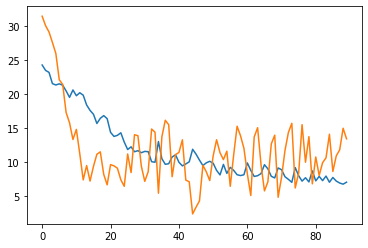

In [ ]:
plt.plot(net_loss_hist)
plt.plot(dsc_loss_hist)

In [ ]:
im=train_set.__getitem__(0)


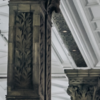

In [ ]:
ToPILImage()(im[0])

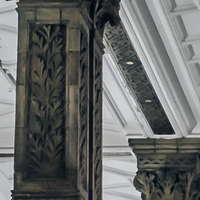

In [ ]:
ToPILImage()(im[1])

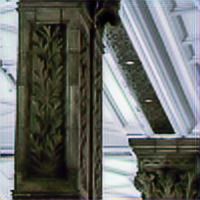

In [ ]:
ToPILImage()(net(im[0][None,:].to(device)).squeeze())

In [ ]:
torch.save(net,'res_model_net.pt')
torch.save(dsc,'res_model_dsc.pt')

In [ ]:
net_cpu=net.to('cpu')
dsc_cpu=dsc.to('cpu')

torch.save(net_cpu,'res_model_net_cpu.pt')
torch.save(net_cpu,'res_model_dsc_cpu.pt')

In [ ]:
net=net.to(device)
dsc=dsc.to(device)

torch.Size([1, 64, 200, 100])

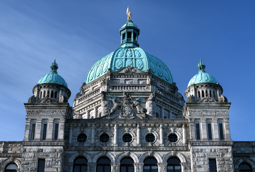

In [ ]:
tpi=ToPILImage()
tt=ToTensor()
a=Image.open('0056x8.png')
a=tt(a)
tpi(a)

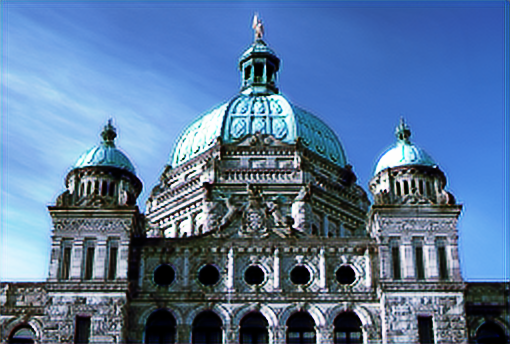

In [ ]:
x=a[None,:].to(device)
y=net(x).squeeze()
tpi(y)


In [ ]:
a.shape

torch.Size([3, 169, 255])